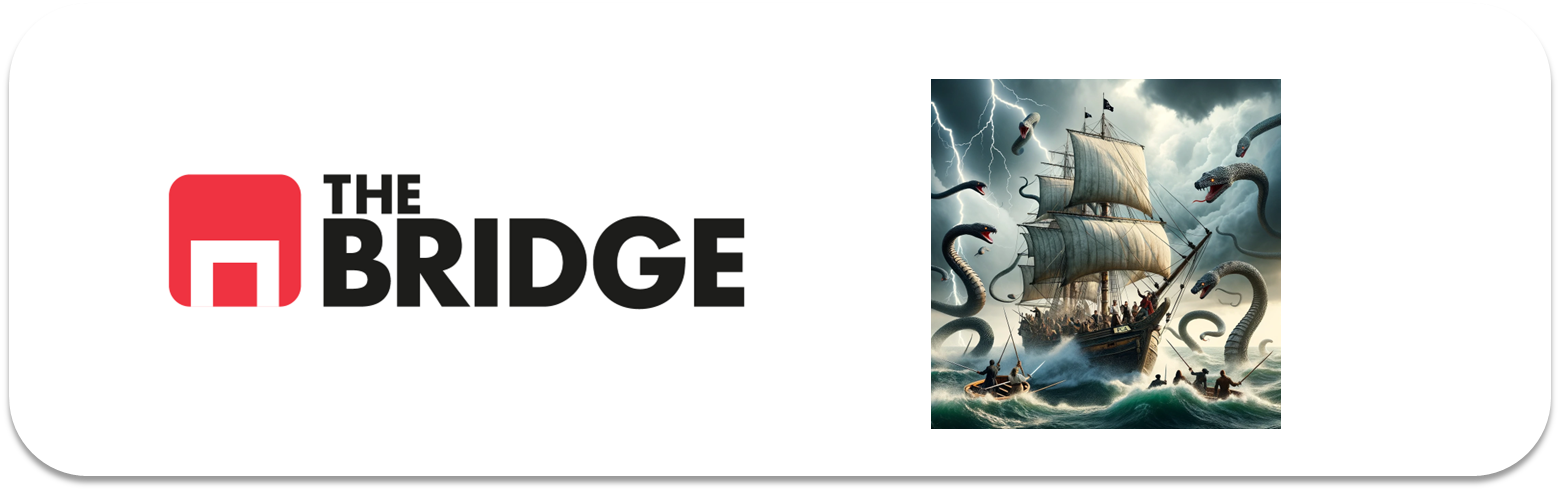

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


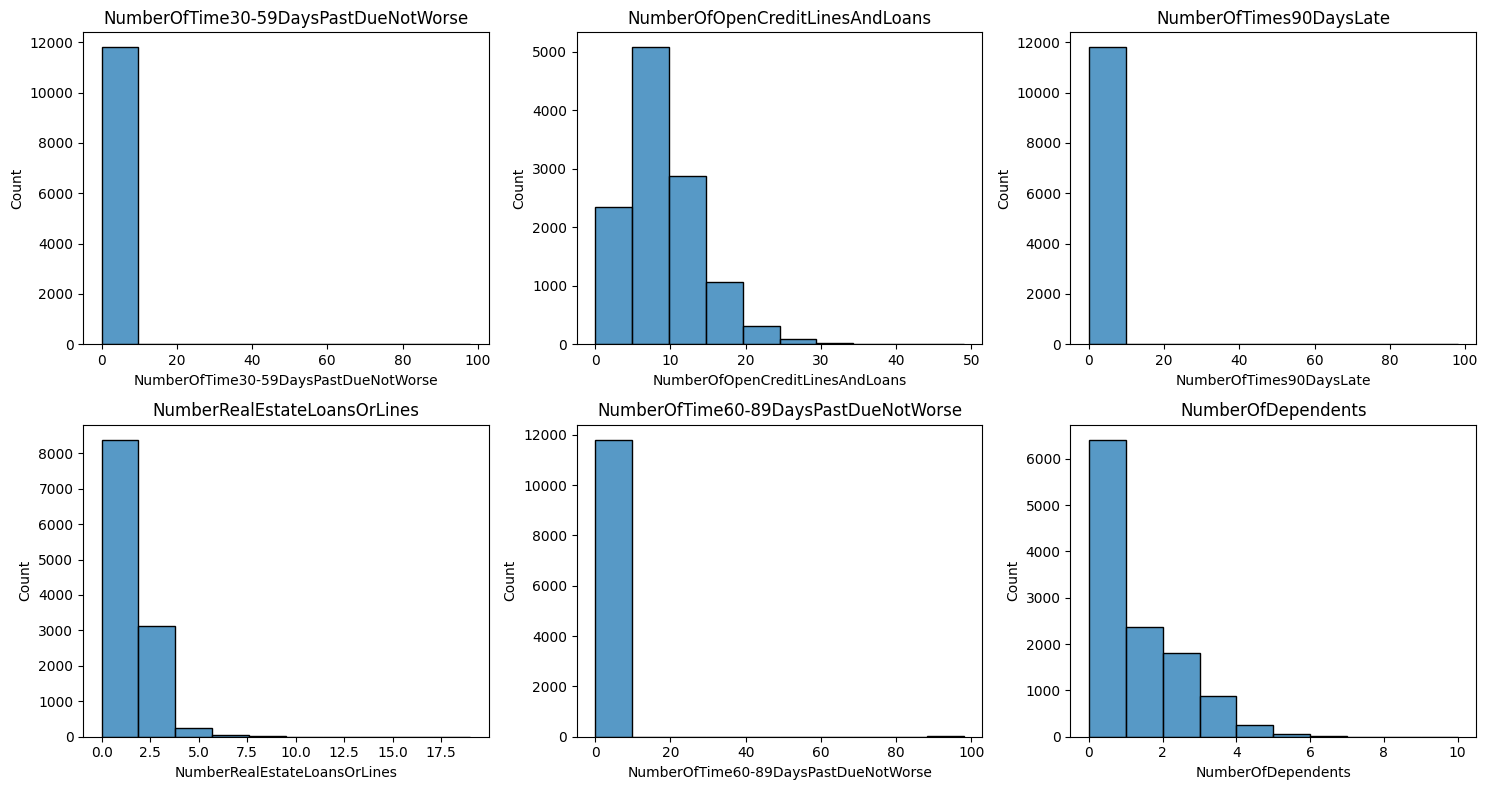

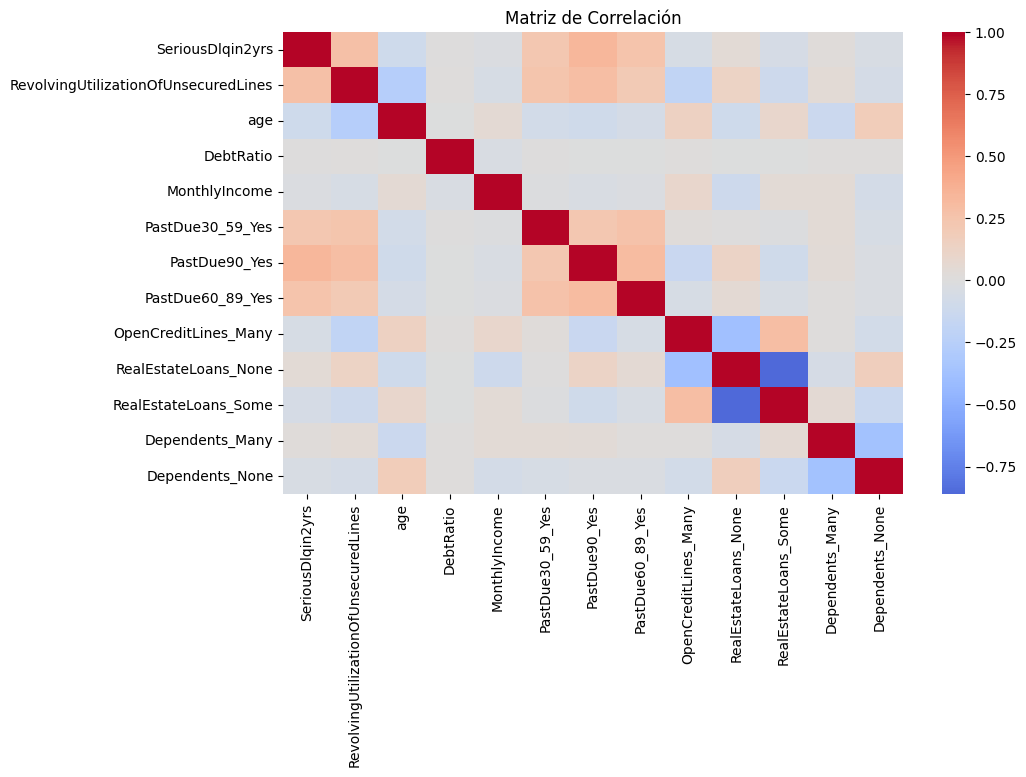

RandomForest Recall Mean: 0.1807
LogisticRegression Recall Mean: 0.1337
SVM Recall Mean: 0.0000
Best Model Test Recall: 0.9169


In [4]:
# Cargar el dataset
file_path = "./data/credit_npo.csv"
df = pd.read_csv(file_path)

# 1. Carga y limpieza de datos
df_clean = df.dropna().reset_index(drop=True)

# 2. Análisis Exploratorio de Datos (EDA)
num_features = [
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfOpenCreditLinesAndLoans",
    "NumberOfTimes90DaysLate",
    "NumberRealEstateLoansOrLines",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfDependents",
]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(num_features):
    sns.histplot(df_clean[col], bins=10, kde=False, ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

# 3. Transformación de variables categóricas
df_clean["PastDue30_59"] = df_clean["NumberOfTime30-59DaysPastDueNotWorse"].apply(lambda x: "No" if x == 0 else "Yes")
df_clean["PastDue90"] = df_clean["NumberOfTimes90DaysLate"].apply(lambda x: "No" if x == 0 else "Yes")
df_clean["PastDue60_89"] = df_clean["NumberOfTime60-89DaysPastDueNotWorse"].apply(lambda x: "No" if x == 0 else "Yes")
df_clean["OpenCreditLines"] = df_clean["NumberOfOpenCreditLinesAndLoans"].apply(lambda x: "Few" if x <= 5 else "Many")
df_clean["RealEstateLoans"] = df_clean["NumberRealEstateLoansOrLines"].apply(lambda x: "None" if x == 0 else ("Some" if x <= 2 else "Many"))
df_clean["Dependents"] = df_clean["NumberOfDependents"].apply(lambda x: "None" if x == 0 else ("Few" if x <= 2 else "Many"))
df_clean.drop(columns=num_features, inplace=True)

# 4. Análisis de correlación y covarianza
df_encoded = pd.get_dummies(df_clean, drop_first=True)
corr_matrix = df_encoded.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Matriz de Correlación")
plt.show()

# 5. Selección de características
num_features = ["RevolvingUtilizationOfUnsecuredLines", "age", "DebtRatio", "MonthlyIncome"]
cat_features = ["PastDue30_59", "PastDue90", "PastDue60_89", "OpenCreditLines", "RealEstateLoans", "Dependents"]

X_num = df_clean[num_features]
y = df_clean["SeriousDlqin2yrs"]
selector_num = SelectKBest(score_func=f_classif, k=3).fit(X_num, y)
best_num_features = [num_features[i] for i in selector_num.get_support(indices=True)]

for col in cat_features:
    df_encoded[col] = LabelEncoder().fit_transform(df_clean[col])
X_cat = df_encoded[cat_features]
selector_cat = SelectKBest(score_func=mutual_info_classif, k=3).fit(X_cat, y)
best_cat_features = [cat_features[i] for i in selector_cat.get_support(indices=True)]

# Selección con modelos (Random Forest, RFE, SFS)
X = pd.get_dummies(df_clean.drop(columns=["SeriousDlqin2yrs"]), drop_first=True)
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X, y)
best_model_features = X.columns[SelectFromModel(rf, threshold="median", prefit=True).get_support()].tolist()

rfe_selector = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=6).fit(X, y)
best_rfe_features = X.columns[rfe_selector.support_].tolist()

X_sample = X.sample(frac=0.3, random_state=42)
y_sample = y.loc[X_sample.index]
sfs_selector = SequentialFeatureSelector(RandomForestClassifier(n_estimators=50, random_state=42), 
                                         n_features_to_select=6, direction="forward", n_jobs=-1).fit(X_sample, y_sample)
best_sfs_features = X.columns[sfs_selector.support_].tolist()

# Hard-voting para selección final
feature_sets = [best_num_features, best_cat_features, best_model_features, best_rfe_features, best_sfs_features]
feature_counts = pd.Series([feat for subset in feature_sets for feat in subset]).value_counts()
best_final_features = feature_counts[feature_counts >= 3].index.tolist()

# 6. Comparación de modelos
models = {
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC()
}
for model_name, model in models.items():
    scores = cross_val_score(model, X[best_final_features], y, cv=5, scoring='recall')
    print(f"{model_name} Recall Mean: {scores.mean():.4f}")

# 7. Optimización del mejor modelo
best_model = RandomForestClassifier()
param_grid = {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='recall').fit(X[best_final_features], y)

# 8. Evaluación final
test_score = recall_score(y, grid_search.best_estimator_.predict(X[best_final_features]))
print(f"Best Model Test Recall: {test_score:.4f}")


### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.